# Scenario C - Peak Variation

In this scenario the number of peaks in a generated dataset is varied in from 2 to 4, 
the rest of the parameters is kept constant (noise level = 1%). The number of peaks expected by the probabilistic model is varied between the low and high peak number.

The model used in the inference of the parameters is formulated as follows:

\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}\big] + \epsilon
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local utility functions

In [2]:
import datetime
import os
import sys
sys.path.append('../../utils')
import utils as utl
import datagen as dg
import models as mdl
import results as res
import figures as fig

## Local settings

In [3]:
# scenario name
scenario = 'peak variation'

# output for results and images
out_path      = './output_adapt_diag/'
fbase         = 'scenario_peaks'
file_basename = out_path + fbase
        
# if dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

# initialization method for sampler
init_mode = 'adapt_diag'

# probabilistic model (priors)
prior_model = 'lognormal'

# provide peak positions to the model as testvalues ('yes'/'no')
peak_info = 'yes'

# model mode ('train'/eval')
model_mode = 'train'

# data mode ('generate'/'preload')
data_mode = 'generate'

# dataset directory
dataset_dir = './input_datasets'

# number of cores to run sampling chains on
ncores = 2

# number of samples per chain
nsamples = 2000

## Save configuration

In [4]:
fp = open(out_path + 'settings.txt', 'w')
fp.write('start: ' + datetime.datetime.now().strftime("%A, %d. %B %Y %I:%M%p") + '\n')
fp.write('scenario    = ' + scenario + '\n')
fp.write('init_mode   = ' + init_mode + '\n')
fp.write('prior_model = ' + prior_model + '\n')
fp.write('peak_info   = ' + peak_info + '\n')
fp.write('model_mode  = ' + model_mode + '\n')
fp.write('data_mode   = ' + data_mode + '\n')
fp.write('ncores      = ' + str(ncores) + '\n')
fp.write('nsamples    = ' + str(nsamples) + '\n')
if data_mode == 'preload':
    fp.write('data_dir    = ' + dataset_dir + '\n')
fp.close()

# Generate data and plot

In [5]:
# list of wavelengths (x-values)
xval = [i for i in range(200, 400, 2)]

ldata  = []
lpeaks = []
nsets  = 1

# number of peaks in the spectrum
peak_numbers = [2, 3, 4, 5]

# total number of datasets
tsets = nsets * len(peak_numbers)
        
if model_mode == 'train' and data_mode == 'generate':
    # generate the datasets
    for pn in peak_numbers:
        for i in range(nsets):
            df, peaks = dg.data_generator(xvalues=xval, nsamples=15, npeaks=pn)
            ldata.append(df)
            lpeaks.append(peaks)
    # save data and peak information to disk
    for i in range(len(ldata)):
        ldata[i].to_csv(out_path + '/dataset_%02d.csv' % (i+1), index=False)
    dg.data_save(out_path + '/peakinfo.csv', lpeaks)
        
elif model_mode == 'train' and data_mode == 'preload':           
    # load pre-generated datasets from disk
    ldata, lpeaks = dg.data_load(tsets, dataset_dir)
    
else:        
    # load data from disk
    if data_mode == 'preload':
        ldata, lpeaks = dg.data_load(tsets, dataset_dir)
    else:
        ldata, lpeaks = dg.data_load(tsets, out_path)

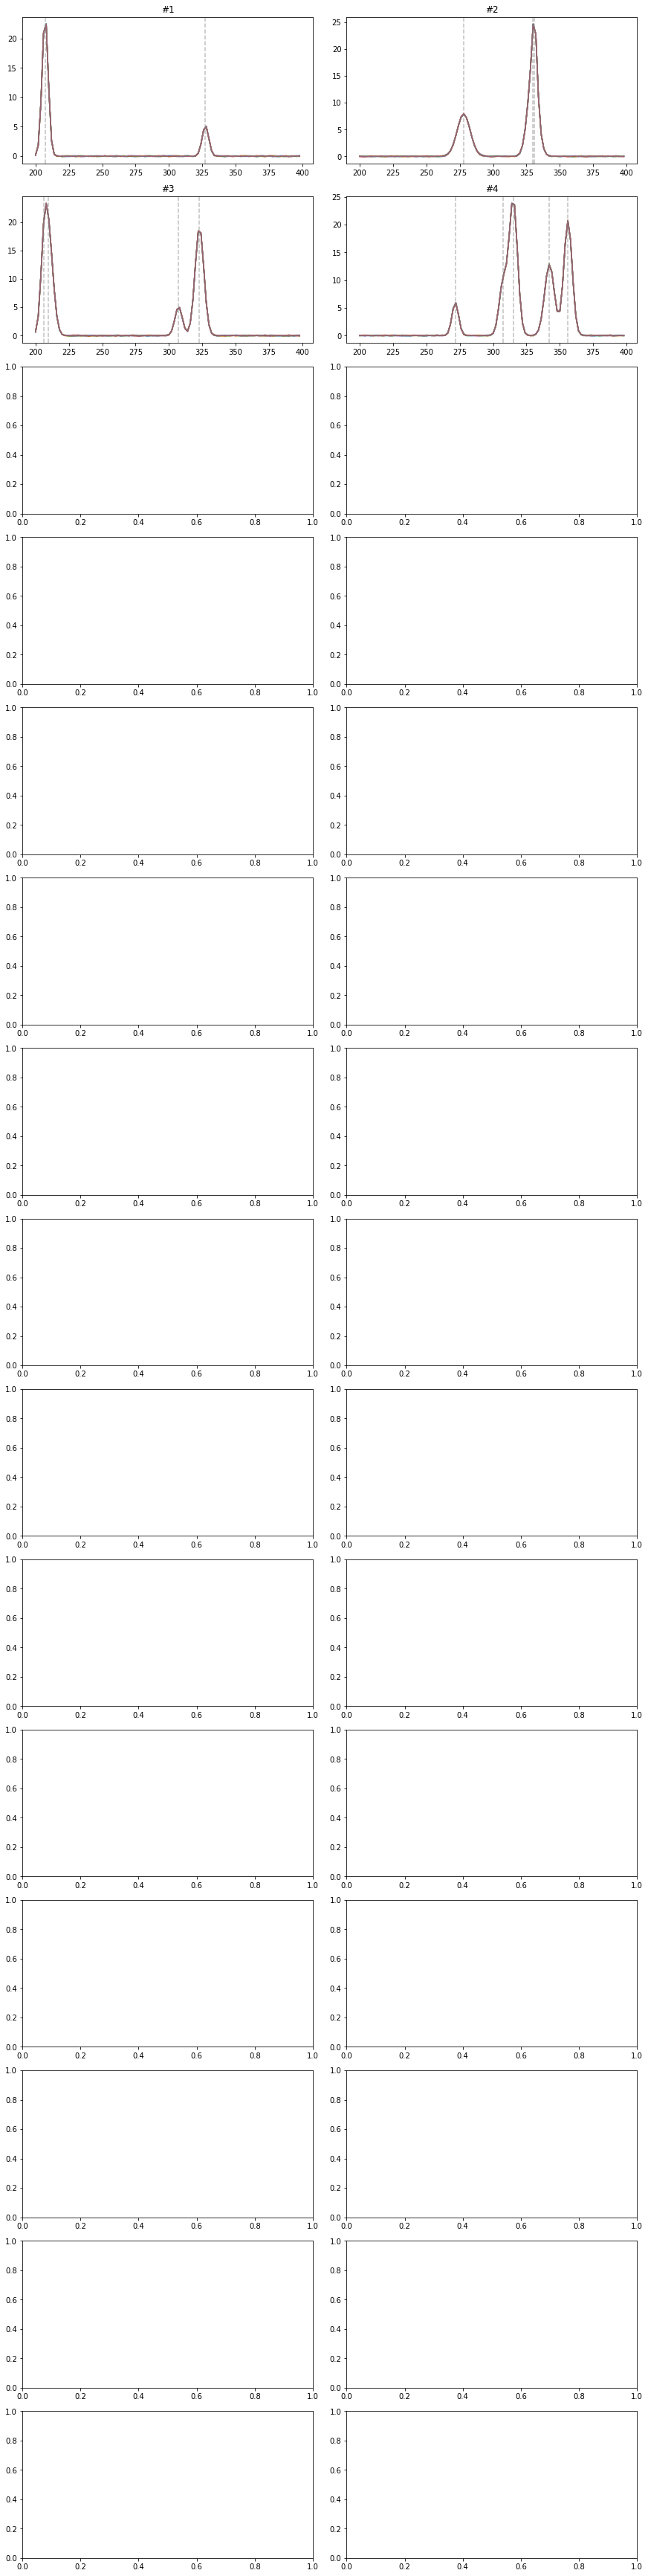

In [6]:
# plot datasets
fig.plot_datasets(ldata, lpeaks, dims=(15,2), figure_size=(12,48), savefig='yes', fname=file_basename)

# Initialize models and run inference

In [ ]:
# convert pandas data to numpy arrays
x_val = np.array(xval, dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values for i in range(len(ldata))]

In [ ]:
# initialize models and run inference
models = []
traces = []

for i in range(len(ldata)):
    if peak_info == 'yes':
        plist = lpeaks[i].flatten()
        plist.sort()
        model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=3, 
                                  mu_peaks=plist, pmodel=prior_model)
    else:
        model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=3,
                                  pmodel=prior_model)      
    models.append(model_g)
    
    with model_g:
        if model_mode == 'train':
            print("running inference on dataset #{0}/{1}".format(i+1,len(ldata)))
            trace_g = pm.sample(nsamples, init=init_mode, cores=ncores)
            traces.append(trace_g)
            # save inference results
            pm.backends.text.dump(out_path + '/traces_%02d' % (i+1), trace_g)
        else:
            # load traces from disk
            print("loading dataset #{0}/{1}".format(i+1,len(ldata)))
            trace_g = pm.backends.text.load(out_path + '/traces_%02d' % (i+1))
            traces.append(trace_g)

# Model visualization

In [ ]:
pm.model_to_graphviz(models[0])

In [ ]:
# save model figure as image
img = pm.model_to_graphviz(models[0])
img.render(filename=file_basename + '_model', format='png');

# Collect results and save

In [ ]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

In [ ]:
# various plots to inspect the inference results
varnames = ['amp', 'mu', 'sigma', 'epsilon']

#az.plot_trace(traces[2], varnames, compact=True);
#az.plot_trace(traces[2], varnames, divergences='top');
#az.plot_autocorr(traces[0], varnames);
#az.plot_posterior(traces[2], varnames);

#for idx, trace in enumerate(traces):
#    az.plot_forest(trace, var_names = varnames, r_hat=True, ess=True);

In [ ]:
if model_mode == 'train':
    # collect the results and display
    df = res.get_results_summary(varnames, traces, ppc, y_val, epsilon_real=lnoise)
else:
    # load results from disk
    df = pd.read_csv(file_basename + '.csv')
    df.index += 1
#df.sort_values(by=['r2'])
df

In [ ]:
if model_mode == 'train':
    # save results to .csv
    df.to_csv(file_basename + '.csv', index=False)

# Plot posterior

In [ ]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(15,2), figure_size=(12,48), savefig='yes', 
                       fname=file_basename, showpeaks='no')

In [ ]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(15,2), figure_size=(12,48), savefig='yes', 
                       fname=file_basename, showpeaks='yes')

In [ ]:
fp = open(out_path + 'settings.txt', 'a')
fp.write('stop : ' + datetime.datetime.now().strftime("%A, %d. %B %Y %I:%M%p") + '\n')
fp.close()